In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-whitegrid')

In [2]:
corte_datos_viejos = '2020-04-29'  #Fecha hasta donde llegaban los datos de la entrega 2

df = pd.read_csv('Base Datos Nueva.csv') 
indonesia = df[df['iso_code'] == 'IDN'].reset_index(drop=True)

In [3]:
def aproximar_ceros(df):
    start = df[df['new_cases'] > 0].index.min()
    for i in range(start, df.index.max()):
        if df.iloc[i, 5] == 0:
            df.iloc[i, 5] = np.abs(df.iloc[i+1, 5] - df.iloc[i-1, 5] ) / 2
    return df

aproximar_ceros(indonesia)

idn = indonesia[indonesia['new_cases'] > 0].reset_index(drop=True)

casos_nuevos = idn['new_cases']
casos_totales = casos_nuevos.cumsum()
fechas = idn.date
dias = np.array(casos_nuevos.index)

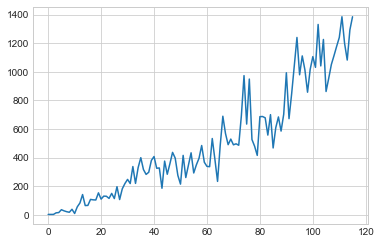

In [4]:
plt.plot(dias, casos_nuevos)

# Definimos Condiciones Iniciales

In [5]:
N = idn.population.mean()

v0 = casos_nuevos[0]  #Cantidad de infectados el primer día registrado
u0 = N - v0           #Toda la poblacion es susceptible menos los dos infectados
w0 = 0                #No hay muertos en el instante 0 

# Función de Avance del PVI (método RK2)

In [6]:
def avance_RK2(h, beta, gamma, dia_max, N=N, u0=u0, v0=v0, w0=w0):
    
    def f1(u, v, beta, N=N):
        return - beta/N * u* v

    def f2(u, v, beta, gamma, N=N):
        return beta/N * u* v - gamma*v

    def f3(v, gamma):
        return gamma*v
    
    
    t = np.arange(0, dia_max+h, h)
    u = np.empty(len(t))
    u[0] = u0
    v = np.empty(len(t))
    v[0] = v0
    w = np.empty(len(t))
    w[0] = w0
    for n in range(len(t)-1):
        u_predictor = u[n] + h/2 * f1(u=u[n], v=v[n], beta=beta)
        v_predictor = v[n] + h/2 * f2(u=u[n], v=v[n], beta=beta, gamma=gamma)
        w_predictor = w[n] + h/2 * f3(v=v[n], gamma=gamma)
        
        u[n+1] = u[n] + h * f1(u=u_predictor, v=v_predictor, beta=beta)
        v[n+1] = v[n] + h * f2(u=u_predictor, v=v_predictor, beta=beta, gamma=gamma)
        w[n+1] = w[n] + h * f3(v=v_predictor, gamma=gamma)
        
    return t, u, v, w

# Calibración de los datos viejos

In [7]:
def norma(l):
    return np.sqrt((l**2).sum())

def ecm_rel(l1, l2):
    '''Calcula el error relativo entre los vectores l1 y l2, tomando como valor de referencia a l1'''
    return norma(l2-l1) / norma(l1)

def error(datos, resultado, h, dia_max):
    '''Calcula el error al aproximar los datos reales con una solucion numerica de paso h'''
    resultado_diario = resultado[[int(n/h) for n in range(dia_max)]]
    return ecm_rel(datos, resultado_diario)

def calibrar_con_sigma(arr_beta, arr_sigma, datos, h=1, dia_max=116):
    '''Prueba todos los valores de beta en el array arr_beta con todos los valores de sigma en el array arr_sigma
    y devuelve el que minimice el error con los datos.'''
    beta = 0
    gamma = 0
    sigma = 0
    e = np.inf
    for b in arr_beta:
        for s in arr_sigma:
            t, u, v, w = avance_RK2(h=h, beta=b, gamma=b/s, dia_max=dia_max)
            err = error(datos, v + w, h=h, dia_max=dia_max)
            if  err < e:
                e = err
                beta = b
                gamma = b/s
                sigma = s
    return beta, gamma, sigma, e

En la siguiente célula se probaron todos los rangos de beta y sigma. Los resultados se presentan en el Anexo A.1.

In [8]:
datos = casos_totales[:52]

arr_beta = np.linspace(20, 21, 100)
arr_sigma = np.linspace(1,1.05, 100)

sol = calibrar_con_sigma(arr_beta, arr_sigma, datos, dia_max=52)

mejor_beta_viejo= sol[0]
mejor_gamma_viejo= sol[1]
mejor_sigma_viejo= sol[2]
error_relativo_viejo = sol[3]


print('Beta: ', mejor_beta_viejo)
print('Gamma: ', mejor_gamma_viejo)
print('Sigma: ',mejor_sigma_viejo)
print('Error: ', sol[3])


Beta:  20.474747474747474
Gamma:  20.423173803526446
Sigma:  1.0025252525252526
Error:  0.06786284697757974


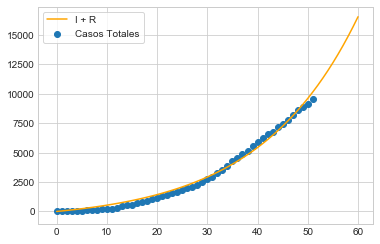

In [9]:
t, u , v, w = avance_RK2(1, beta=mejor_beta_viejo, gamma=mejor_gamma_viejo, dia_max=60)


fig, ax = plt.subplots()

ax.plot(t, v + w, c='orange', label='I + R')
ax.scatter(casos_totales.index[:52], casos_totales[:52], label='Casos Totales')
ax.legend(frameon=True)


In [10]:
t, u , v, w = avance_RK2(1, beta=mejor_beta_viejo, gamma=mejor_gamma_viejo, dia_max=130)
t1, u1 , v1, w1 = avance_RK2(0.1, beta=mejor_beta_viejo, gamma=mejor_gamma_viejo, dia_max=130)

ecm_rel(w1[[n*10 for n in range(131)]],w )

0.0014848253319154044

### Figura 1: Datos viejos Vs. Parámetros viejos

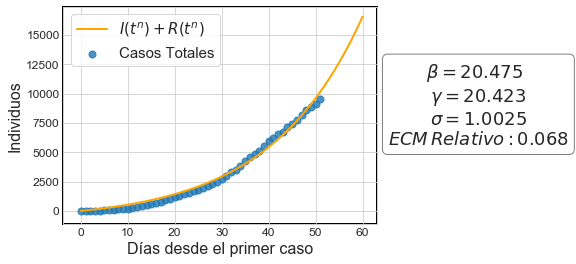

In [11]:
t, u , v, w = avance_RK2(1, beta=mejor_beta_viejo, gamma=mejor_gamma_viejo, dia_max=60)


fig, ax = plt.subplots(figsize=(8.3,4))

fig.subplots_adjust(right=0.65)


ax.plot(t, v + w, c='orange', label=r'$I(t^{n}) + R(t^{n})$', lw=2)
ax.scatter(casos_totales.index[:52], casos_totales[:52], label='Casos Totales', s=50, alpha=0.8)
ax.legend(frameon=True, fontsize=15)
ax.set_ylabel('Individuos', fontsize=16)
ax.set_xlabel('Días desde el primer caso', fontsize=16)
ax.tick_params(labelsize=12)

valores =  r"""$ \beta = {0} \ $ 
$\gamma = {1} \ $
$\sigma = {2} \ $
$ECM \, Relativo: {3}$""".format(round(mejor_beta_viejo,3),round(mejor_gamma_viejo,3),round(mejor_sigma_viejo,4), round(error_relativo_viejo,3)) 

style=dict(size=18)
props = dict(boxstyle="round", fc="none", ec="gray")

ax.text(0.82, 0.4, valores, transform=fig.transFigure, ha='center', bbox=props, **style)


ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('2')

#fig.savefig('Figura1.png')

### Figura 2: SIR parámetros viejos

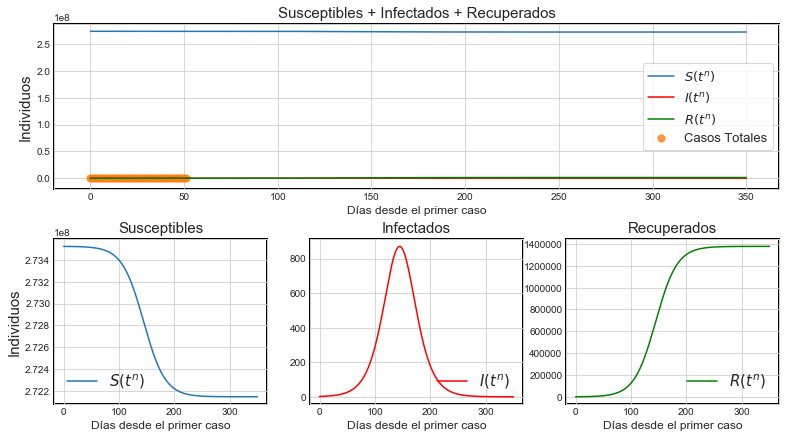

In [12]:
t, u , v, w = avance_RK2(0.1, beta=mejor_beta_viejo, gamma=mejor_gamma_viejo, dia_max=350)

fig, axs = plt.subplots(1, 3, figsize=(13,7), sharex=True)

grid= plt.GridSpec(2, 3, wspace=0.2, hspace=0.3)

SIR = plt.subplot(grid[0, :])
S = plt.subplot(grid[1, 0])
I = plt.subplot(grid[1, 1])
R = plt.subplot(grid[1, 2])

SIR.plot(t, u, c='C0', label=r'$S(t^{n})$')
SIR.plot(t,v, c='red', label= r'$I(t^{n})$')
SIR.plot(t,w, c='green', label=r'$R(t^{n})$')
SIR.scatter(casos_totales.index[:52], casos_totales[:52], label='Casos Totales', c='C1', s=50, alpha=0.8)
SIR.legend(frameon=True, fontsize=13)
SIR.set_title('Susceptibles + Infectados + Recuperados', size=15)
SIR.set_ylabel('Individuos', size=15)
SIR.set_xlabel('Días desde el primer caso', size=12)


S.plot(t, u, c='C0', label=r'$S(t^{n})$')
S.set_title('Susceptibles', size=15)
S.set_ylabel('Individuos', size=15)
S.set_xlabel('Días desde el primer caso', size=12)
S.legend(loc='lower left', fontsize=15)

I.plot(t,v, c='red', label=r'$I(t^{n})$')
I.set_title('Infectados', size=15)
I.set_xlabel('Días desde el primer caso', size=12)
I.legend(loc='lower right', fontsize=15)


R.plot(t,w, c='green', label=r'$R(t^{n})$' )
R.set_title('Recuperados', size=15)
R.set_xlabel('Días desde el primer caso', size=12)
R.legend(loc='lower right', fontsize=15)

axs = [SIR, S, I ,R]

for ax in axs:
    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth('2')

#fig.savefig('Figura2.png')

In [13]:
print(v.max())
print(v.argmax()/10)

repr(pd.to_datetime(fechas.iloc[0]) + pd.Timedelta(145, unit='days'))

print(w[-1] / N)

870.4540001632434
144.5
0.005036307509194088


### Figura 3: Datos nuevos Vs. Parámetros viejos

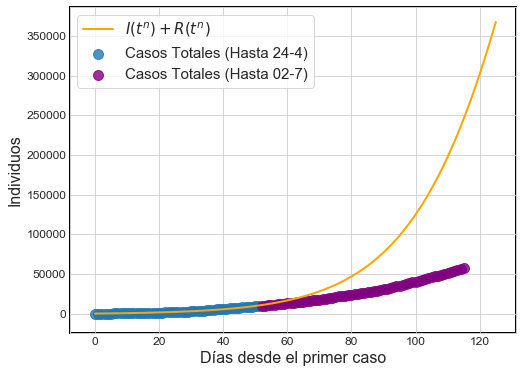

In [14]:
t, u , v, w = avance_RK2(1, beta=mejor_beta_viejo, gamma=mejor_gamma_viejo, dia_max=125)


fig, ax = plt.subplots(figsize=(8,6))

ax.plot(t, v + w, c='orange', label=r'$I(t^{n}) + R(t^{n})$', lw=2)
ax.scatter(casos_totales.index[:52], casos_totales[:52], label='Casos Totales (Hasta 24-4)', s=100, alpha=0.8)
ax.scatter(casos_totales.index[52:], casos_totales[52:], label='Casos Totales (Hasta 02-7)', s=100, alpha=0.8, c='purple')
ax.legend(frameon=True, fontsize=15)
ax.set_ylabel('Individuos', fontsize=16)
ax.set_xlabel('Días desde el primer caso', fontsize=16)
ax.tick_params(labelsize=12)

ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('2') 


#fig.savefig('Figura3.png')


# Calibración de los datos nuevos

Acá se calibró el modelo con los datos actualizados, utilizando la misma función de calibración que antes.

In [15]:
datos = casos_totales

arr_beta = np.linspace(18, 18.5, 100)
arr_sigma = np.linspace(1,1.05, 50)


sol = calibrar_con_sigma(arr_beta, arr_sigma, datos)

mejor_beta= sol[0]
mejor_gamma= sol[1]
mejor_sigma= sol[2]
error_relativo = sol[3]


print('Beta: ', mejor_beta)
print('Gamma: ', mejor_gamma)
print('Sigma: ',mejor_sigma)
print('Error: ', error_relativo)


Beta:  18.318181818181817
Gamma:  18.280873912238473
Sigma:  1.0020408163265306
Error:  0.15120837652953822


### Figura 4: Datos nuevos, parámetros nuevos

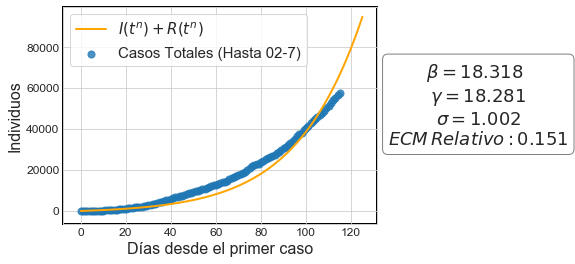

In [16]:
t, u , v, w = avance_RK2(1, beta=mejor_beta, gamma=mejor_gamma, dia_max=125)


fig, ax = plt.subplots(figsize=(8.3,4))

fig.subplots_adjust(right=0.65)


ax.plot(t, v + w, c='orange', label=r'$I(t^{n}) + R(t^{n})$', lw=2)
ax.scatter(casos_totales.index, casos_totales, label='Casos Totales (Hasta 02-7)', s=50, alpha=0.8)
ax.legend(frameon=True, fontsize=15)
ax.set_ylabel('Individuos', fontsize=16)
ax.set_xlabel('Días desde el primer caso', fontsize=16)
ax.tick_params(labelsize=12)

valores =  r"""$ \beta = {0} \ $ 
$\gamma = {1} \ $
$\sigma = {2} \ $
$ECM \, Relativo: {3}$""".format(round(mejor_beta,3),round(mejor_gamma,3),round(mejor_sigma,4), round(error_relativo,3)) 

style=dict(size=18)
props = dict(boxstyle="round", fc="none", ec="gray")

ax.text(0.82, 0.4, valores, transform=fig.transFigure, ha='center', bbox=props, **style)

ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('2') 

#fig.savefig('Figura4.png')

### Figura 5: SIR parámetros nuevos

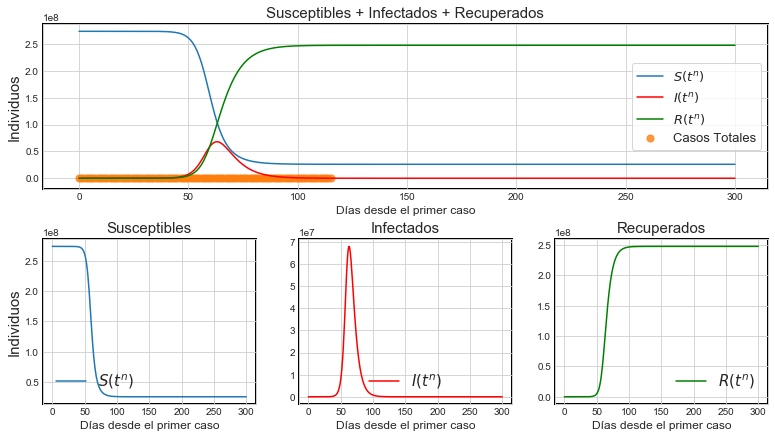

In [17]:
t, u , v, w = avance_RK2(1, beta=0.5, gamma=0.192, dia_max=300)

fig, axs = plt.subplots(1, 3, figsize=(13,7), sharex=True)

grid= plt.GridSpec(2, 3, wspace=0.2, hspace=0.3)

SIR = plt.subplot(grid[0, :])
S = plt.subplot(grid[1, 0])
I = plt.subplot(grid[1, 1])
R = plt.subplot(grid[1, 2])

SIR.plot(t, u, c='C0', label=r'$S(t^{n})$')
SIR.plot(t,v, c='red', label= r'$I(t^{n})$')
SIR.plot(t,w, c='green', label=r'$R(t^{n})$')
SIR.scatter(casos_totales.index, casos_totales, label='Casos Totales', c='C1', s=50, alpha=0.8)
SIR.legend(frameon=True, fontsize=13)
SIR.set_title('Susceptibles + Infectados + Recuperados', size=15)
SIR.set_ylabel('Individuos', size=15)
SIR.set_xlabel('Días desde el primer caso', size=12)


S.plot(t, u, c='C0', label=r'$S(t^{n})$')
S.set_title('Susceptibles', size=15)
S.set_ylabel('Individuos', size=15)
S.set_xlabel('Días desde el primer caso', size=12)
S.legend(loc='lower left', fontsize=15)

I.plot(t,v, c='red', label=r'$I(t^{n})$')
I.set_title('Infectados', size=15)
I.set_xlabel('Días desde el primer caso', size=12)
I.legend(loc='lower center', fontsize=15)


R.plot(t,w, c='green', label=r'$R(t^{n})$' )
R.set_title('Recuperados', size=15)
R.set_xlabel('Días desde el primer caso', size=12)
R.legend(loc='lower right', fontsize=15)

axs = [SIR, S, I ,R]

for ax in axs:
    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth('2') 

#fig.savefig('Figura5.png')

### Figura 6: Nuevos infectados Vs. pico

0.507703982111737

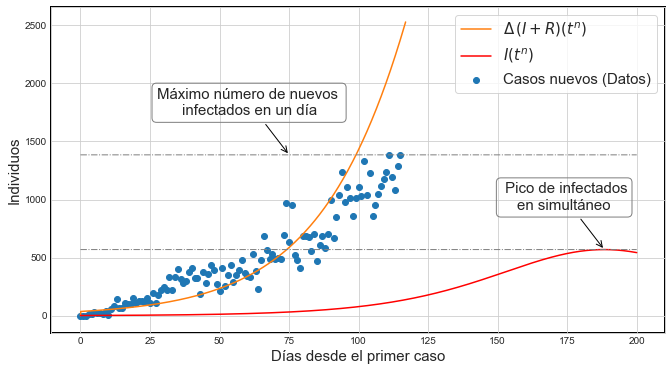

In [18]:
t, u , v, w = avance_RK2(0.1, beta=mejor_beta, gamma=mejor_gamma, dia_max=200)
casos_nuevos_RK2 = np.empty(len(t)+1)
casos_nuevos_RK2[0] = 0
for i in range(1,len(t)):
    casos_nuevos_RK2[i] = ((w+v)[i] - (w+v)[i-1])/0.1
    

fig = plt.figure(figsize=(11,6))
ax = plt.axes()

ax.plot(t[:117*10], casos_nuevos_RK2[:117*10], c='C1', label= r'$ \Delta \,  (I+R)(t^{n})$')
ax.scatter(dias, casos_nuevos, label='Casos nuevos (Datos)')
ax.plot(t, v, c='red', label=r'$I(t^{n})$')
ax.legend(fontsize=15, frameon=True)
ax.set_ylabel('Individuos', size=15)
ax.set_xlabel('Días desde el primer caso', size=15)

ax.plot(t, np.full(len(t),v.max()), ls='-.', c='gray', lw=1)
ax.plot(t, np.full(len(t), casos_nuevos.iloc[-1]), ls='-.', c='gray', lw=1)

texto1 = """ Pico de infectados
en simultáneo"""

ax.annotate(texto1, xy=(v.argmax()/10, v.max()),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(-40, 40), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"), fontsize=15)

texto2 = """Máximo número de nuevos 
infectados en un día"""

ax.annotate(texto2, xy=(75, casos_nuevos.iloc[-1]),  xycoords='data',
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(-40, 40), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->"), fontsize=15)

ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('2') 

error(casos_nuevos, casos_nuevos_RK2, 0.1, 116)

#fig.savefig('Figura6.png')

# Función de avance del PVI (método Crank-Nicholson)

In [19]:
def avance_CN_Gauss_Seidel(h, beta, gamma, dia_max, N=N, u0=u0, v0=v0, w0=w0, tol=1e-5):
    
    t = np.arange(0, dia_max+h, h)
    u = np.empty(len(t))
    u[0] = u0
    v = np.empty(len(t))
    v[0] = v0
    w = np.empty(len(t))
    w[0] = w0
    
    def g1(x, y, n):
        return u[n] - h/2 * beta / N *(x * y + u[n]*v[n]) 
    def g2(x, y, n):
        return v[n] + h/2 * (beta / N * (x*y + u[n]*v[n]) - gamma*(y + v[n]))  
    
    for n in range(len(t)-1):
        x = u[n]
        y = v[n]
        err = tol * 1.1
        
        while err > tol:
            
            x_sig = g1(x, y, n)
            y_sig = g2(x_sig, y, n)
            
            err = max(np.abs(x - x_sig), np.abs(y - y_sig))
            
            x = x_sig
            y = y_sig
        
        u[n+1] = x
        v[n+1] = y
        w[n+1] = w[n] + h/2 * gamma* (v[n+1] + v[n])
             
    return t, u, v, w

# Comparación gráfica de los métodos

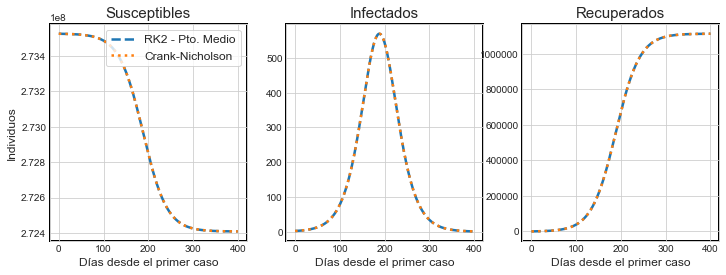

In [20]:
def graficar_metodos():
    fig, axs = plt.subplots(1,3,figsize=(12,4), sharex=True)

    clases = ['Susceptibles', 'Infectados', 'Recuperados']

    t1, u1, v1, w1 = avance_RK2(h=0.1, beta=mejor_beta, gamma=mejor_gamma, dia_max=400)
    t2, u2 , v2, w2 = avance_CN_Gauss_Seidel(h=0.1, beta=mejor_beta, gamma=mejor_gamma, dia_max=400, tol=1e-5)

    datos_A = [u1, v1, w1]
    datos_B = [u2, v2, w2]

    for i in range(3):
        axs[i].plot(t1, datos_A[i], ls='--', label='RK2 - Pto. Medio', lw=2.5)
        axs[i].plot(t2, datos_B[i], ls=':', label='Crank-Nicholson', lw=2.5)
        axs[i].set_title(clases[i], size=15)
        axs[i].set_xlabel('Días desde el primer caso', size=12)
        axs[i].patch.set_edgecolor('black')  
        axs[i].patch.set_linewidth('2') 
        

        
    axs[0].set_ylabel('Individuos', size=12)
    axs[0].legend(frameon=True, fontsize=12, loc='upper right')

    #fig.savefig('Figura7.png')
    return

graficar_metodos()
        

In [21]:
t, u , v, w = avance_RK2(0.1, beta=mejor_beta, gamma=mejor_gamma, dia_max=400)

t2, u2 , v2, w2 = avance_CN_Gauss_Seidel(0.1, beta=mejor_beta, gamma=mejor_gamma, dia_max=400, tol=1e-10)

t3, u3 , v3, w3 = avance_CN_Gauss_Seidel(0.1, beta=mejor_beta, gamma=mejor_gamma, dia_max=400, tol=0.1)

print(max(ecm_rel(u, u2), ecm_rel(v, v2), ecm_rel(w, w2)))
print(max(ecm_rel(u, u3), ecm_rel(v, v3), ecm_rel(w, w3)))

4.9231905014133986e-06
1.4290603486935025e-06


# Aproximación del valor del pico de contagios

In [22]:
t, u , v, w = avance_RK2(0.01, beta=mejor_beta, gamma=mejor_gamma, dia_max=400)

def i_max(sigma):
    return (u0 + v0)/N - 1/sigma - 1/sigma*np.log(sigma * u0 / N)

i_max_T = i_max(mejor_sigma)  #Valor teórico del pico de infectados normalizado
i_max_N = v.max() / N         #Valor numérico


print(i_max_T)
print(i_max_N)
print(np.abs(i_max_N - i_max_T) / i_max_T)

2.0826982604182746e-06
2.082698277721898e-06
8.30827196779703e-09


# ENL Para $\large{s_{\infty}}$

In [23]:
def newton_raphson(x0, g, tol):
    x_sig = g(x0)
    x = x0
    while np.abs(x_sig - x) > tol:
        x = x_sig
        x_sig = g(x_sig)
    return x_sig

def funcion_iteradora(x, i0=(v0/N), s0=(u0/N), sigma=mejor_sigma):
    return x - (i0 + s0 - x + 1/sigma*np.log(x/s0)) / (-1 + 1/(sigma*x))

s_inf_T = newton_raphson(0.8, funcion_iteradora, 1e-10)

s_inf_T

0.9959258774432294

### Figura 8: $\large{s_{\infty}}$

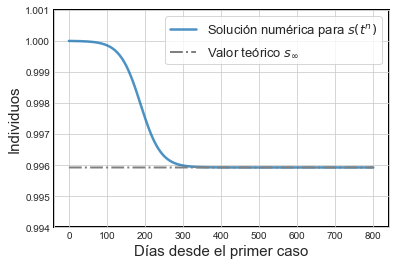

In [24]:
t, u , v, w = avance_RK2(0.1, beta=mejor_beta, gamma=mejor_gamma, dia_max=800)

fig = plt.figure()
ax = plt.axes()

ax.plot(t, u/N, label= r'Solución numérica para $s(t^{n})$', lw=2.5, alpha=0.8)
ax.plot(t, np.full(len(t), s_inf_T), ls='-.', c='gray', label=r'Valor teórico $s_{\infty}$', lw=2)
ax.set_ylim(0.994,1.001)
ax.set_xlabel('Días desde el primer caso', size=15)
ax.set_ylabel('Individuos', size=15)
ax.legend(frameon=True, fontsize=13)

ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('2')


#fig.savefig('Figura8.png')


In [25]:
s_365_N = u[3650] / N
s_548_N = u[5480] / N
s_730_N = u[7300] / N

print(s_inf_T)
print(s_365_N)
print(np.abs(s_365_N - s_inf_T) / s_inf_T)
print(s_548_N)
print(np.abs(s_548_N - s_inf_T) / s_inf_T)
print(s_730_N)
print(np.abs(s_730_N - s_inf_T) / s_inf_T)


0.9959258774432294
0.9959314323854231
5.577666289831703e-06
0.9959258834562247
6.037593218599056e-09
0.9959258774508307
7.632459558351379e-12


# Aproximación de Sigma

In [26]:
def sigma_aprox(s_inf):
    return np.log(u0/N/s_inf) / (u0/N - s_inf)

print('sigma aprox:', sigma_aprox(s_730_N))
print('Mejor sigma:', mejor_sigma)

sigma aprox: 1.0020426147267525
Mejor sigma: 1.0020408163265306


In [27]:
i_max(sigma_aprox(s_730_N)) * N

570.6663876872105

In [28]:
i_max(mejor_sigma) * N

569.6671696400075

In [29]:
i_max(1.003) * N

1226.7199476272174

# Conservación de N (Ambos métodos)

### Figura 9

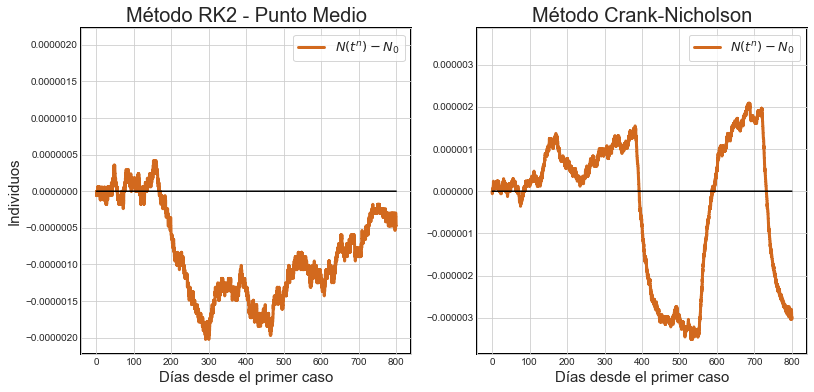

In [30]:
t, u , v, w = avance_RK2(0.1, beta=mejor_beta, gamma=mejor_gamma, dia_max=800)

t2, u2 , v2, w2 = avance_CN_Gauss_Seidel(0.1, beta=mejor_beta, gamma=mejor_gamma, dia_max=800, tol=1e-5)

fig, axs = plt.subplots(1, 2,figsize=(13,6), sharex=True)

axs[0].plot(t, u+v+w - N, c='chocolate', lw=3)
axs[0].set_ylabel('Individuos', size=15)

y0lim_abs = np.abs((u+v+w) - N).max() * 1.1
axs[0].set_ylim(top=y0lim_abs, bottom=-(y0lim_abs))

axs[1].plot(t2, u2+v2+w2 - N, c='chocolate', lw=3)

y1lim_abs = np.abs((u2+v2+w2) - N).max() * 1.1
axs[1].set_ylim(top=y1lim_abs, bottom=-(y1lim_abs))
#axs[1].set_yticks([100*n for n in range(-5,6)])

titulos = ['Método RK2 - Punto Medio', 'Método Crank-Nicholson']

for i in range(len(axs)):
    axs[i].plot(t, np.zeros(len(t)), 'k')
    axs[i].legend([r"$ N(t^{n}) - N_{0} $"], frameon=True, fontsize=13)
    axs[i].set_title(titulos[i], size=20)
    axs[i].set_xlabel('Días desde el primer caso', size=15)
    axs[i].patch.set_edgecolor('black')  
    axs[i].patch.set_linewidth('2')


    
#fig.savefig('Figura9.png')

# Orden Método A

In [31]:
class Solucion_Numerica:
    
    def __init__(self, arr, h):
        self.arr = np.array(arr)
        self.h = h
    
    def __getitem__(self, dia):
        return self.arr[int(dia/self.h)]
    
    def comparar(self, dia, other):
        return np.abs(self[dia] - other[dia])


href = 2**(-10)
ref_A = avance_RK2(href, beta=mejor_beta, gamma=mejor_gamma, dia_max=300)

uref_A = Solucion_Numerica(ref_A[1], href)
vref_A = Solucion_Numerica(ref_A[2], href)
wref_A = Solucion_Numerica(ref_A[3], href)

def orden_metodo_A(hmax, hmin, dia, uref=uref_A, vref=vref_A, wref=wref_A):
    paso = np.array([2**n for n in range(hmax, hmin, -1)])
    error_u = np.empty(hmax - hmin)
    error_v = np.empty(hmax - hmin)
    error_w = np.empty(hmax - hmin)
    for i in range(len(paso)):
        h = paso[i]
        sol = avance_RK2(h, beta=mejor_beta, gamma=mejor_gamma, dia_max=300)
        u = Solucion_Numerica(sol[1], h)
        v = Solucion_Numerica(sol[2], h)
        w = Solucion_Numerica(sol[3], h)
        error_u[i] = round(u.comparar(dia, uref),6)
        error_v[i] = round(v.comparar(dia, vref),6)
        error_w[i] = round(w.comparar(dia, wref),6)
    
    resultado = pd.DataFrame({'Error S': error_u, 'Error I': error_v, 'Error R': error_w}, index=paso)
    resultado.index.name = r'$h$'
    return resultado

In [32]:
tabla1 = orden_metodo_A(4, -7, 200)

pd.set_option("display.precision", 6)
#tabla1.to_csv("Tabla1.csv")

tabla1

,Error S,Error I,Error R
$h$,,,
16.000000,120840.906737,40.926753,120881.833482
8.000000,9435.747093,7.339508,9443.086592
4.000000,2587.082452,1.903865,2588.986308
2.000000,682.410497,0.486504,682.896992
1.000000,175.558034,0.123063,175.681088
0.500000,44.542175,0.030952,44.573119
0.250000,11.219164,0.007762,11.226917
0.125000,2.815259,0.001943,2.817193
0.062500,0.705013,0.000486,0.705490


In [33]:
t166, u166 , v166, w166 = avance_RK2(16, beta=mejor_beta, gamma=mejor_gamma, dia_max=800)

u16 = Solucion_Numerica(u166, 16)
v16 = Solucion_Numerica(v166, 16)
w16 = Solucion_Numerica(w166, 16)


u16.comparar(200, uref_A) / uref_A[200]
v16.comparar(200, vref_A) / vref_A[200]
w16.comparar(200, wref_A) / wref_A[200]

0.1786982858725372

# Orden Método B

In [ ]:
href = 2**(-10)
ref_B = avance_CN_Gauss_Seidel(href, beta=mejor_beta, gamma=mejor_gamma, dia_max=300)

uref_B = Solucion_Numerica(ref_B[1], href)
vref_B = Solucion_Numerica(ref_B[2], href)
wref_B = Solucion_Numerica(ref_B[3], href)

def orden_metodo_B(hmax, hmin, dia, uref=uref_B, vref=vref_B, wref=wref_B, tol=1e-5):
    paso = np.array([2**n for n in range(hmax, hmin, -1)])
    error_u = np.empty(hmax - hmin)
    error_v = np.empty(hmax - hmin)
    error_w = np.empty(hmax - hmin)
    for i in range(len(paso)):
        h = paso[i]
        sol = avance_CN_Gauss_Seidel(h, beta=mejor_beta, gamma=mejor_gamma, dia_max=300, tol=tol)
        u = Solucion_Numerica(sol[1], h)
        v = Solucion_Numerica(sol[2], h)
        w = Solucion_Numerica(sol[3], h)
        error_u[i] = round(u.comparar(dia, uref),6)
        error_v[i] = round(v.comparar(dia, vref),6)
        error_w[i] = round(w.comparar(dia, wref),6)
    
    resultado = pd.DataFrame({'Error S': error_u, 'Error I': error_v, 'Error R': error_w}, index=paso)
    resultado.index.name = r'$h$'
    return resultado

In [ ]:
tabla2 = orden_metodo_B(4, -7, 200, tol=1e-5)



#tabla2.to_csv('Tabla2.csv')
tabla2

# Costo Computacional (Ambos métodos)

In [ ]:
import datetime

def cronometro(h, metodo, runs, loops, tol=1e-5):
    '''Registra el tiempo que tarda el método A o B en resolver el PVI y devuelve la informacion necesaria
    para construir una flia de la Tabla 3'''
    tiempos = np.empty(runs)
    
    if metodo.upper() == 'A':
        tol = np.nan
        for r in range(runs):
            iniciar = datetime.datetime.now()
            for l in range(loops):
                x = avance_RK2(h, beta=mejor_beta, gamma=mejor_gamma, dia_max=300)
            terminar = datetime.datetime.now()

            delta = terminar - iniciar
            tiempos[r] = delta.total_seconds() / loops * 1000

    else:
        for r in range(runs):
            iniciar = datetime.datetime.now()
            for l in range(loops):
                x = avance_RK2(h, beta=mejor_beta, gamma=mejor_gamma, dia_max=300)
            terminar = datetime.datetime.now()

            delta = terminar - iniciar
            tiempos[r] = delta.total_seconds() / loops * 1000
    
    media = round(tiempos.mean(),2)
    std = round(tiempos.std(),2)
    
    tiempo = r'$ {0} \pm {1}$'.format(media, std)
    
    s1 = 's'
    if runs == 1: s1 = ''
    
    s2 = 's'
    if loops == 1: s2=''
    descr = f'{runs} vuelta{s1} de {loops} corrida{s2}'
    return [eval(repr(metodo)), h, tol, tiempo, descr]

In [ ]:
cronometro(0.1,'A', 1, 1)

In [ ]:
class TablaCrono():
    
    def __init__(self):
        self.tabla = pd.DataFrame({'Método': [], 'Paso': [], 'Tolerancia': [], 'Tiempo medio (ms)': [], 'Descripción': [] })
        self.nfilas = 0
    
    def agregar_fila(self, h, metodo, runs, loops, tol=1e-5):
        self.tabla.loc[self.nfilas+1] = cronometro(h, metodo, runs, loops, tol)
        self.nfilas +=1
        return self.tabla
    
    def show(self):
        return self.tabla
    
    def guardar(self):
        self.tabla.to_csv('Tabla3.csv')
        print('Tabla guardada como "Tabla3.csv"')
        return
    
tabla3 = TablaCrono()

pd.set_option("display.precision", 2)

tabla3.agregar_fila(1,'A', 7, 100)
tabla3.agregar_fila(0.1,'A', 7, 10)
tabla3.agregar_fila(0.01,'A', 7, 1)
tabla3.agregar_fila(0.001,'A', 1, 1)


tabla3.agregar_fila(1,'B', 7, 100,tol=1e-1)
tabla3.agregar_fila(1,'B', 7, 100,tol=1e-5)
tabla3.agregar_fila(1,'B', 7, 100,tol=1e-10)

tabla3.agregar_fila(0.1,'B', 7, 10,tol=1e-5)
tabla3.agregar_fila(0.01,'B', 7, 1,tol=1e-5)
tabla3.agregar_fila(0.001,'B', 1, 1,tol=1e-5)

#tabla3.guardar()
tabla3.show()

# Anexo B.1

In [ ]:
def graficar_metodos():
    fig, axs = plt.subplots(1,3,figsize=(12,4), sharex=True)

    clases = ['Susceptibles', 'Infectados', 'Recuperados']

    t1, u1, v1, w1 = avance_RK2(h=40, beta=mejor_beta, gamma=mejor_gamma, dia_max=800)
    t2, u2 , v2, w2 = avance_CN_Gauss_Seidel(h=0.1, beta=mejor_beta, gamma=mejor_gamma, dia_max=800)

    datos_A = [u1, v1, w1]
    datos_B = [u2, v2, w2]

    for i in range(3):
        axs[i].plot(t1, datos_A[i], label=r'RK2 $h=40$', lw=2.5)
        axs[i].plot(t2, datos_B[i],c='k', ls='-.', label=r'Referencia')
        axs[i].set_title(clases[i], size=15)
        axs[i].set_xlabel('Días desde el primer caso', size=12)
        axs[i].patch.set_edgecolor('black')  
        axs[i].patch.set_linewidth('2') 
        

        
    axs[0].set_ylabel('Individuos', size=12)
    axs[0].legend(frameon=True, fontsize=12, loc='upper right')

    #fig.savefig('FiguraB1.png')
    return

graficar_metodos()

# Anexo C.1

In [ ]:
dias = [50, 100, 150, 300]

for i in range(4):
    tablaA = orden_metodo_A(4, -7, dias[i])
    #tablaA.to_csv(f'TablaC1{i+1}.csv')

# Anexo C.2

In [ ]:
dias = [50, 100, 150, 300]

for i in range(4):
    tablaB = orden_metodo_A(4, -7, dias[i])
    #tablaB.to_csv(f'TablaC2{i+1}.csv')

# Anexo C.3

In [ ]:
def graficar_metodos():
    fig, axs = plt.subplots(1,3,figsize=(12,4), sharex=True)

    clases = ['Susceptibles', 'Infectados', 'Recuperados']

    t1, u1, v1, w1 = avance_RK2(h=16, beta=mejor_beta, gamma=mejor_gamma, dia_max=400)
    t2, u2 , v2, w2 = avance_RK2(h=2**(-10), beta=mejor_beta, gamma=mejor_gamma, dia_max=400)

    datos_A = [u1, v1, w1]
    datos_B = [u2, v2, w2]

    for i in range(3):
        axs[i].plot(t1, datos_A[i], label=r'$h=16$', lw=2.5)
        axs[i].plot(t2, datos_B[i],c='k', ls='-.', label=r'$h=2^{-10}$')
        axs[i].set_title(clases[i], size=15)
        axs[i].set_xlabel('Días desde el primer caso', size=12)
        axs[i].patch.set_edgecolor('black')  
        axs[i].patch.set_linewidth('2') 
        

        
    axs[0].set_ylabel('Individuos', size=12)
    axs[0].legend(frameon=True, fontsize=12, loc='upper right')

    #fig.savefig('FiguraC3.png')
    return

graficar_metodos()

# Espacio de Fase

In [ ]:
t, u , v, w = avance_RK2(0.1, beta=mejor_beta, gamma=mejor_gamma, dia_max=800)

fig = plt.Figure()

ax = plt.axes()

ax.plot(u/N, v/N)

def flechita(locs):
    for i in locs:
        plt.arrow(u[i], v[i], u[i+100], v[i+100] - v[i], shape='full', lw=0, length_includes_head=True, head_width=.05)
    return

#flechita([2000])